# 56_RNN - 감성분석

# 감성분석
### 감성분석 Sentiment Analysis
- 입력된 자연어 안의 주관적 의견, 감정 등을 찾아내는 문제
- 이중 문장의 긍정/부정 등을 구분하는 경우가 많음

In [2]:
train_text = open('./dataset/nsmc/ratings_train.txt', 'rb').read().decode(encoding='utf-8')
                                    # rb : r = open for reading / b = binary mode
test_text = open('./dataset/nsmc/ratings_test.txt', 'rb').read().decode(encoding='utf-8')

print('Length of text : {} characters'.format(len(train_text)))
print('Length of text : {} characters'.format(len(test_text)))
print()

print(train_text[:300])

Length of text : 6937271 characters
Length of text : 2318260 characters

id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의


In [3]:
train_text[:300]

'id\tdocument\tlabel\n9976970\t아 더빙.. 진짜 짜증나네요 목소리\t0\n3819312\t흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나\t1\n10265843\t너무재밓었다그래서보는것을추천한다\t0\n9045019\t교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정\t0\n6483659\t사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다\t1\n5403919\t막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.\t0\n7797314\t원작의'

> ## \t, \n 등이 있다.

------------
# 데이터 전처리

In [4]:
# 1 줄바꿈 (\n)
train_text.split('\n')[:3]

['id\tdocument\tlabel',
 '9976970\t아 더빙.. 진짜 짜증나네요 목소리\t0',
 '3819312\t흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나\t1']

In [5]:
# 2 탭 문자 ('\t')
train_text.split('\n')[3].split('\t')

['10265843', '너무재밓었다그래서보는것을추천한다', '0']

In [6]:
import numpy as np 

train_Y = np.array([[int(row.split('\t')[2])] for row in train_text.split('\n')[1:] if row.count('\t') > 0])
                                                        # train_text.split('\n')[0] = 'id\tdocument\tlabel'
                                                                                        # row : ['9976970\t아 더빙.. 진짜 짜증나네요 목소리\t0', '3819312\t흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나\t1', ... ]
test_Y = np.array([[int(row.split('\t')[2])] for row in test_text.split('\n')[1:] if row.count('\t') > 0])

print(train_Y.shape, test_Y.shape)
print(train_Y[:5])      # label print

(150000, 1) (50000, 1)
[[0]
 [1]
 [0]
 [0]
 [1]]


-----------------
# tokenization 와 cleaning
- ### `tokenization` : 자연어를 처리 가능한 최소의 단위로 나누는 것으로 여기서는 띄어쓰기로 한다.
- ### `cleaning` : 불필요한 기호를 제거하는 것

In [7]:
# 1 cleaning 함수

## 문장을 띄워서 분류할 예정
import re

def clean_str(string):
    string = re.sub(r"[^가-힣A-Za-z0-9(),!?\'\`]", " ", string)
                        # 바꿔야 할 리스트
                                                    # 바뀌게 될 문장

    string = re.sub(r"\'s", " \'s", string)         # He 's
    string = re.sub(r"\'ve", " \'ve", string)       # I 've
    string = re.sub(r"n\'t", " n\'t", string)       # He can 't
    string = re.sub(r"\'re", " \'re", string)       # you 're
    string = re.sub(r"\'d", " \'d", string)         # I 'd
    string = re.sub(r"\'ll", " \'ll", string)       # they 'll
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)     # \s{2,} : white spaces, 공백이 {2,} 2개 이상인 경우 >> ' ' 하나만 표현
    string = re.sub(r"\'{2,}", "\'", string)    # \'{2,} : '이 {2,} 2개 이상인 경우 >> ' 하나만 표현
    string = re.sub(r"\'", "", string)          # \' : ' 이 1개만 있는 경우 >> 공란으로 표현

    return string.lower()

------------------------

In [8]:
# 훈련용 데이터 전처리 완료
train_text_X = [row.split('\t')[1] for row in train_text.split('\n')[1:] if row.count('\t') > 0]
train_text_X = [clean_str(sentence) for sentence in train_text_X]

sentences = [sentence.split(' ') for sentence in train_text_X]
for i in range(5):
    print(sentences[i])

['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조차', '가볍지', '않구나']
['너무재밓었다그래서보는것을추천한다']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그의', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨에서', '늙어보이기만', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


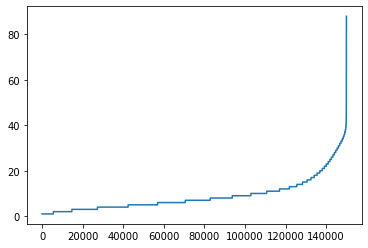

142587


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

sentence_len = [len(sentence) for sentence in sentences]
sentence_len.sort()
plt.plot(sentence_len)
plt.show()

print(sum([int(l<=25) for l in sentence_len]))

> - ### 단어가 0 ~ 90 개 정도의 문장(sentence)을 plot으로 나타냄.
> - ### 140,000개 정도의 문장들이 단어가 20개를 넘지 못하는 것을 볼 수 있다.

## 데이터 크기 맞추기
- 학습을 위해 네트워크에 입력을 넣을 때 입력 데이터는 그 크기가 같아야 한다.
- 입력 벡터의 크기를 맞춰야 하는데
- 여기서는 긴 문장은 줄이고, 짧은 문장은 공백으로 채우자
- 15만개의 문장 중에 대부분이 40단어 이하로 되어있다.

In [10]:
sentences_new  = []
for sentence in sentences:
    sentences_new.append([word[:5] for word in sentence][:25])

sentences = sentences_new
for i in range(5):
    print(sentences[i])

['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조', '가볍지', '않구나']
['너무재밓었']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨', '늙어보이기', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


In [13]:
# 토크나이징 과 패딩
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(sentences)
train_X = tokenizer.texts_to_sequences(sentences)
train_X = pad_sequences(train_X, padding='post')

print(train_X[:5])

# 25개가 안되는 단어는 0을 채운다.

[[   25   884     8  5795  1111     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [  588  5796  6697     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [   71   346    31    35 10468     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [  106  5338     4     2  2169   869   573     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]]


In [14]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(20000, 300, input_length=25),
    tf.keras.layers.LSTM(units=50),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

2022-06-27 12:20:00.010393: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-27 12:20:00.012628: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 300)           6000000   
                                                                 
 lstm (LSTM)                 (None, 50)                70200     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 6,070,302
Trainable params: 6,070,302
Non-trainable params: 0
_________________________________________________________________


# 임베딩 레이어
- 임베딩 레이어 (`embedding layer`) : 자연어를 수치화된 정보로 바꾸기 위한 레이어
- 자연어는 시간의 흐름에 따라 정보가 연속적으로 이어지는 시퀀스 데이터
- 영어는 문자단위, 한글은 문자를 넘어 자소 단위로도 쪼개기도 함. 혹은 띄어쓰기나 형태소로 나누기도 함
- 여러 단어로 묶어서 사용하는 n-gram 방식도 있음
- 여기에 원핫인코딩까지 포함

In [15]:
# 학습
history = model.fit(train_X, train_Y, epochs = 5, batch_size = 128, validation_split=0.2)

Epoch 1/5


2022-06-27 13:34:30.948701: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-27 13:34:32.718035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-27 13:34:33.102841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-27 13:34:35.059081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.4340 - accuracy: 0.7852

2022-06-27 13:35:29.590066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-27 13:35:29.666874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 61s 60ms/step - loss: 0.4340 - accuracy: 0.7852 - val_loss: 0.3815 - val_accuracy: 0.8205
Epoch 2/5
938/938 [==============================] - 57s 61ms/step - loss: 0.3272 - accuracy: 0.8462 - val_loss: 0.3893 - val_accuracy: 0.8213
Epoch 3/5
938/938 [==============================] - 54s 58ms/step - loss: 0.2761 - accuracy: 0.8669 - val_loss: 0.4279 - val_accuracy: 0.8168
Epoch 4/5
938/938 [==============================] - 54s 58ms/step - loss: 0.2325 - accuracy: 0.8851 - val_loss: 0.4723 - val_accuracy: 0.8150
Epoch 5/5
938/938 [==============================] - 57s 61ms/step - loss: 0.1982 - accuracy: 0.9015 - val_loss: 0.5726 - val_accuracy: 0.8123


In [16]:
# test
test_sentence = '재미있을 줄 알았는데 완전 실망했다. 너무 졸리고 돈이 아까웠다.'
test_sentence = test_sentence.split(' ')
test_sentences=[]
now_sentence = []
for word in test_sentence:
    now_sentence.append(word)
    test_sentences.append(now_sentence[:])

test_X_1 = tokenizer.texts_to_sequences(test_sentences)
test_X_1 = pad_sequences(test_X_1, padding='post', maxlen=25)
prediction = model.predict(test_X_1)
for idx, sentence in enumerate(test_sentences):
    print(sentence)
    print(prediction[idx])

2022-06-27 13:47:33.381213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-27 13:47:33.512336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step
['재미있을']
[0.38167733 0.6183227 ]
['재미있을', '줄']
[0.3066469 0.6933532]
['재미있을', '줄', '알았는데']
[0.39499375 0.6050063 ]
['재미있을', '줄', '알았는데', '완전']
[0.46894252 0.5310575 ]
['재미있을', '줄', '알았는데', '완전', '실망했다.']
[0.46894252 0.5310575 ]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무']
[0.56424236 0.4357577 ]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고']
[0.9936923  0.00630777]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고', '돈이']
[0.9989774  0.00102259]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고', '돈이', '아까웠다.']
[0.9989774  0.00102259]
